In [1]:
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pickle
import random
import numpy as np
from nltk.util import ngrams
from sys import platform

# To make sure the folder standards work in windows and other systems
if platform == "win32":
    # Windows...
    folder_separator = "\\"
else:
    folder_separator = "/"
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

To represent our words as vectors, we use one-hot encoding. Each word is then a large vector full of zeroes, with a one in the position of the word. The size of the vector is the length of the vocabulary. The following helper class creates a Lang object, which is useful for making our one-hot encoded word vectors. The Lang object contains two dictionaries: a word2index dictionary that has each word of our vocabulary as keys, and its index in the vector as value. The other dictionary is index2word, which does the same but is reversed. It also keeps track of how many words we have, in a word2count dictionary.

In [2]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

We then make two Lang classes from our dataset. The Lang class stores useful information about the words and indexes in our one-hot encoded vector. We use these classes for training. The input language is going to be English, and the output language will be Dutch. Also, in this step each input sentence is reversed.

In [3]:
def lang_class_maker(data, lang1, lang2):
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    
    for pair in data:
        # The sentence is splitted, reversed, and reassembled
        input_sentence = " ".join(pair[0].split()[::-1])
        input_lang.addSentence(input_sentence)
        output_lang.addSentence(pair[1])
        
    return input_lang, output_lang

Below follow the encoder, decoder and attention decoder classes, as described by the [Pytorch tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html).

In [4]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [5]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [6]:
MAX_LENGTH = 20 # This depends on the length of sentences in our sample set. For actual training it needs to be higher.

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

We need the following helper functions for our training. When given a pair of sentences, we want to make two tensors from them, containing the indexes of each word in the sentence.

In [7]:
def indexesFromSentence(lang, sentence):
    total = list()
    for word in sentence.split(" "):
        try:
            total.append(lang.word2index[word])
        except:
            print(f"This is the word: {word}")
            raise Exception("We fucked up, and its a key error")
    return total


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

The following two functions are very useful for the human operator at the computer. The first one shows a plot with the cost per amount of iterations, which helps with determining how fast the model improves, and gives an indication of how many iterations we should use. The second one calculates the amount of time that went by, and the amount of time left until the training is completed.

In [8]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [9]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

Now we are finally ready for training, which we will do with the following two functions. The first one trains for one sentence pair. The second one iterates a certain amount of times, and trains one pair of sentences in each iteration.

In [10]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    # Use its own predictions as the next input
    for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

Here we can put the different tweaks to the models. The first one is to use teacher forcing. This basically uses the target sentence (given from the data) as input in the Recurrent Neural Network, so the model already knows the target sentence and tries to approximate this. The teacher forcing ratio can be specified in the input, and is a number between 0 and 1, indicating in how much of the cases we will apply teacher forcing.

In [11]:
def train_teacher(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, 
                  max_length=MAX_LENGTH, teacher_forcing_ratio=0.5):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [12]:
def trainIters(encoder, decoder, pairs, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(pairs[i]) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_teacher(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

After the model has been trained, we also want to be able to test what it's output is. The following function takes the trained encoder and decoder, and an English sentence as input, and produces a Dutch translation as output.

In [13]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [14]:
def bleu_text(target_text: list, reference_text: list, n_precision = 4, smoothing = 0):
    """takes a target_text, and a reference_text, of the same length, as lists within lists, where each inner list is a
    tokenized sentence, n_precision, which determines up to which n-gram the bleu value is computed, and a possible
    smoothing"""
    temp = np.zeros((n_precision, 2)) #each row is an n(-gram), column 0 is counted matches, column 1 is total n-grams
    for i in range(0, len(target_text)):
        for j in range(0, n_precision):
            count = 0
            target = list(ngrams(target_text[i], j+1))
            reference = list(ngrams(reference_text[i], j+1))
            for x in target:
                #to make sure no n-gram is used as a match twice, it is removed from the reference list
                if x in reference:
                    reference.remove(x)
                    count += 1
            #if a smoothing is specified, and for a certain n-gram 0 counts were found, it is smoothed over
            if smoothing != 0 and count == 0:
                count = smoothing
            temp[j] += [count, len(target)]
    #the amount of matches will be divided by the total amount of n-grams
    result = temp[:,0]/temp[:,1]
    #the final result will be the geometric mean of the different n-gram results
    return result.prod()**(1/len(result))

Loading...
En/De coding...
Training...
Saving...
Loading...
En/De coding...
(['oké,', 'steek', 'nu', 'over'], ['costa', 'priester', 'werken,', 'het,', 'gast', 'rapport', 'rapport', 'rapport', 'rapport', 'rapport', 'ga', 'ga', 'hoe', 'doen', 'ga', 'hoe', 'doen', 'ga', 'doen', 'ga', 'hoe', 'doen', 'ga', 'ga', 'doen', 'ga', 'doen', 'ga', 'ga', 'mee', 'ga', 'doen', 'ga', 'ga', 'mee', 'werken,', 'werken,', 'gast', 'gast', 'rapport', 'rapport', 'rapport', 'rapport', 'telefoon', 'hoe', 'ga', 'hoe', 'doen', 'ga', 'hoe', 'ga', 'hoe', 'doen', 'ga', 'hoe', 'doen', 'ga', 'hoe', 'werken,', 'gast'])
(['klopt,', 'maar', 'ik', 'probeer', 'het', 'wel'], ['gisteren', 'gisteren', 'dak', 'doen', 'ga', 'hoe', 'werken,', 'werken,', 'gast', 'rapport', 'rapport', 'rapport', 'rapport', 'rapport', 'ga', 'ga', 'doen', 'ga', 'doen', 'ga', 'ga', 'hoe', 'hoe', 'doen', 'ga', 'hoe', 'doen', 'ga', 'hoe', 'doen', 'ga', 'hoe', 'werken,', 'werken,', 'gast', 'doen', 'gast', 'rapport', 'rapport', 'rapport', 'rapport', 'tel

RuntimeError: Error(s) in loading state_dict for EncoderRNN:
	size mismatch for embedding.weight: copying a param with shape torch.Size([605, 256]) from checkpoint, the shape in current model is torch.Size([317, 256]).

<Figure size 432x288 with 0 Axes>

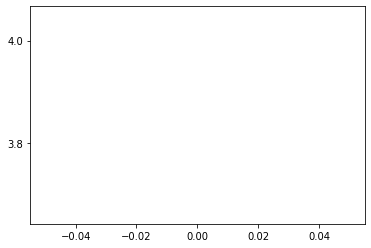

In [16]:
# This initializes the encoder and the attention decoder. We can choose to specify the amount of hidden layers
hidden_size = 256
training_chunk_num = 8
test_chunk_num = 3
initialized = False
show_progress = True
pickle_off = f"data{folder_separator}data/sample_not_a_sample.pkl"

file_stream = (open(pickle_off, "rb"))
while training_chunk_num:
    try:
        # Read the pickle manually, to keep track of the stream
        print("Loading...")
        pairs = pickle.load(file_stream)
        random.shuffle(pairs)
        input_lang, output_lang = lang_class_maker(pairs, 'en', 'nl')

        # Prepare the encoder and the attention decoder
        print("En/De coding...")
        encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
        attndecoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)
        
        # Load the previous states if its already initialized
        if initialized:            
            # To show progress, we can evaluate each step with the next chunk before using
            # it on training
            if show_progress:
                to_be_evaluated=[[],[]]

                for pair in pairs:
                    to_be_evaluated[0].append(pair[1].split(' '))
                    to_be_evaluated[1].append(evaluate(encoder1, attndecoder1, pair[0]))

                for i in range(3):
                    print((to_be_evaluated[0][i], to_be_evaluated[1][i]))

                print(bleu_text(to_be_evaluated[0], to_be_evaluated[1]))
            
            encoder1.load_state_dict(torch.load(f'models{folder_separator}model1encoder.pt'))
            attndecoder1.load_state_dict(torch.load(f'models{folder_separator}model1attn_decoder.pt'))
        else:
            initialized = True

        # This actually trains the model. The good part about this is that you can interrupt or stop it for a bit, and run it again
        # later, to continue the same training.
        # Fix the third value to 10000, and the last to 200. Added a new input of pairs to be sure
        print("Training...")
        trainIters(encoder1, attndecoder1, pairs, len(pairs), print_every=200)
        
        # To save the model
        print("Saving...")
        torch.save(encoder1.state_dict(), f'models{folder_separator}model1encoder.pt')
        torch.save(attndecoder1.state_dict(), f'models{folder_separator}model1attn_decoder.pt')
        
        training_chunk_num -= 1
    # This exception shows when the set is not divided to the exact number of expected chunks
    except EOFError:
        raise Exception("You have reached the end of chunks")


while test_chunk_num:
    try:
        print("Testing chunk...")
        pairs = pickle.load(file_stream)
        to_be_evaluated=[[],[]]

        for pair in pairs:
            to_be_evaluated[0].append(pair[1].split(' '))
            to_be_evaluated[1].append(evaluate(encoder1, decoder1, pair[0]))
            
        for i in range(3):
            print((to_be_evaluated[0][i], to_be_evaluated[1][i]))
        
        print(bleu_text(to_be_evaluated[0], to_be_evaluated[1]))
        
        test_chunk_num -= 1
    except EOFError:
        raise Exception("You have reached the end of chunks")